Pre-requisite is the earnings from alpha vantage, clean and combined stock data from kaggle and ticker data also from kaggle. These are processed and extracted from previous analysis

In [ ]:
import pandas as pd
import numpy as np

def build_event_and_strategy_df(stock_df, earnings_df, ticker_df, window=5):
    # Step 1: Clean & Convert Dates
    stock_df["Date"] = pd.to_datetime(stock_df["Date"])
    earnings_df["reported_date_clean"] = pd.to_datetime(earnings_df["reported_date_clean"])

    # Step 2: Sort for merge
    stock_df = stock_df.sort_values(["Ticker", "Date"])

    # Step 3: Build event windows
    event_rows = []
    for (ticker, reported_date) in earnings_df[["symbol", "reported_date_clean"]].dropna().values:
        price_df = stock_df[stock_df["Ticker"] == ticker]
        idx = price_df[price_df["Date"] == reported_date].index
        if len(idx) == 0:
            continue
        loc = price_df.index.get_loc(idx[0])
        start = max(0, loc - window)
        end = min(len(price_df), loc + window + 1)
        window_df = price_df.iloc[start:end].copy()
        window_df["Days_From_Earnings"] = np.arange(start - loc, end - loc)
        window_df["Earnings_Date"] = reported_date
        window_df["symbol"] = ticker
        # Merge EPS info
        for col in ['actual_eps', 'estimated_eps', 'surprise', 'surprise_pct']:
            window_df[col] = earnings_df[(earnings_df["symbol"] == ticker) &
                                         (earnings_df["reported_date_clean"] == reported_date)][col].values[0]
        event_rows.append(window_df)

    event_df = pd.concat(event_rows).reset_index(drop=True)

    # Step 4: Add Next Day Open
    event_df["Next_Day_Open"] = event_df.groupby("Ticker")["Open"].shift(-1)

    # Step 5: Add Return Metrics
    event_df["Regular_Change%"] = 100 * (event_df["Close"] - event_df["Open"]) / event_df["Open"]
    event_df["After_Hours_Change%"] = 100 * (event_df["Next_Day_Open"] - event_df["Close"]) / event_df["Close"]

    # Step 6: Merge Ticker Metadata
    enriched_df = pd.merge(event_df, ticker_df, how="left", left_on="Ticker", right_on="Ticker")

    # Rename EPS fields
    enriched_df = enriched_df.rename(columns={
        "surprise": "EPS_Surprise",
        "surprise_pct": "EPS_Surprise_%",
        "actual_eps": "EPS_Actual",
        "estimated_eps": "EPS_Estimate"
    })

    # Reorder for modeling
    strategy_cols = [
        'Ticker', 'Earnings_Date', 'Date', 'Days_From_Earnings',
        'Open', 'Close', 'Next_Day_Open',
        'Regular_Change%', 'After_Hours_Change%', 'EPS_Actual', 'EPS_Estimate',
        'EPS_Surprise', 'EPS_Surprise_%',
        'Sector', 'Industry', 'Profitable', 'Founder_is_CEO',
        'FemaleCEO', 'Growth_in_Jobs'
    ]
    strategy_df = enriched_df[strategy_cols].dropna()

    return strategy_df


strategy_df_5 = build_event_and_strategy_df(cleaned_stock_data, combined_alpha_earnings_data, ticker_df, window=5)
strategy_df_5.to_csv("/content/strategy_df_window5.csv", index=False)
strategy_df_5.head()


Need strategy_df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load required datasets (replace with your own if needed)
alpha_df = combined_alpha_earnings_data.copy()

# 2. Merge alpha_df to strategy_df to ensure consistency in available tickers
available_tickers = set(strategy_df["Ticker"].unique())
relevant_tickers = ticker_df[ticker_df["Ticker"].isin(available_tickers)]

# 3. Sort by MarketCap or Revenue
top_tickers_df = relevant_tickers.sort_values(by="MarketCap_March28_M", ascending=False).head(10)
top_tickers = top_tickers_df["Ticker"].tolist()

print(f"🎯 Analyzing top tickers: {top_tickers}")

# 4. Function to train and evaluate model
def evaluate_ticker_model(ticker, df):
    df_ticker = df[df["Ticker"] == ticker].copy()
    df_ticker = df_ticker.dropna(subset=["After_Hours_Change%"])

    if len(df_ticker) < 50:
        return {"Ticker": ticker, "RMSE": None, "R2": None, "Samples": len(df_ticker)}

    y = df_ticker["After_Hours_Change%"]
    X = df_ticker.drop(columns=["Ticker", "Date", "Earnings_Date", "Company", "After_Hours_Change%", "Regular_Change%"])
    cols_to_drop = ["Ticker", "Date", "Earnings_Date", "Company", "After_Hours_Change%", "Regular_Change%"]
    existing_cols = [col for col in cols_to_drop if col in df_ticker.columns]
    X = df_ticker.drop(columns=existing_cols)


    # Handle NaNs
    X = X.replace([np.inf, -np.inf], np.nan)
    for col in X.columns:
        if X[col].dtype in ["float64", "int64"]:
            X[col] = X[col].fillna(0)
        else:
            X[col] = X[col].fillna("missing")

    # Column types
    num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    return {"Ticker": ticker, "RMSE": round(rmse, 4), "R2": round(r2, 4), "Samples": len(df_ticker)}

# 5. Run for each ticker
results = [evaluate_ticker_model(t, strategy_df) for t in top_tickers]
results_df = pd.DataFrame(results)

# 6. Save and display
results_df.to_csv("ticker_model_performance.csv", index=False)
print("✅ Saved to ticker_model_performance.csv")
results_df
rfr_results_df = results_df.copy()



In [1]:
import google.colab
import os
from google.colab import files
uploaded = files.upload()

Saving combined_model_performance.csv to combined_model_performance.csv


In [2]:
import pandas as pd
combined_model_performance = pd.read_csv("combined_model_performance.csv")
combined_model_performance

,Ticker,RMSE,R2,Samples,Model
0,AAPL,NaN,NaN,34,Random Forest
1,AAPL,NaN,NaN,34,XGBoost
2,AMZN,9.4722,0.1523,713,Random Forest
3,AMZN,8.1423,0.3736,713,XGBoost
4,JPM,5.2232,0.5304,741,Random Forest
5,JPM,4.4169,0.6642,741,XGBoost
6,MSFT,3.7681,0.4777,741,Random Forest
7,MSFT,2.9839,0.6724,741,XGBoost
8,NVDA,20.6502,0.1229,643,Random Forest
9,NVDA,18.6401,0.2853,643,XGBoost


<ipython-input-3-904936ae88ba>:16: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-904936ae88ba>:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("rmse_comparison.png")  # Save for dashboard
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


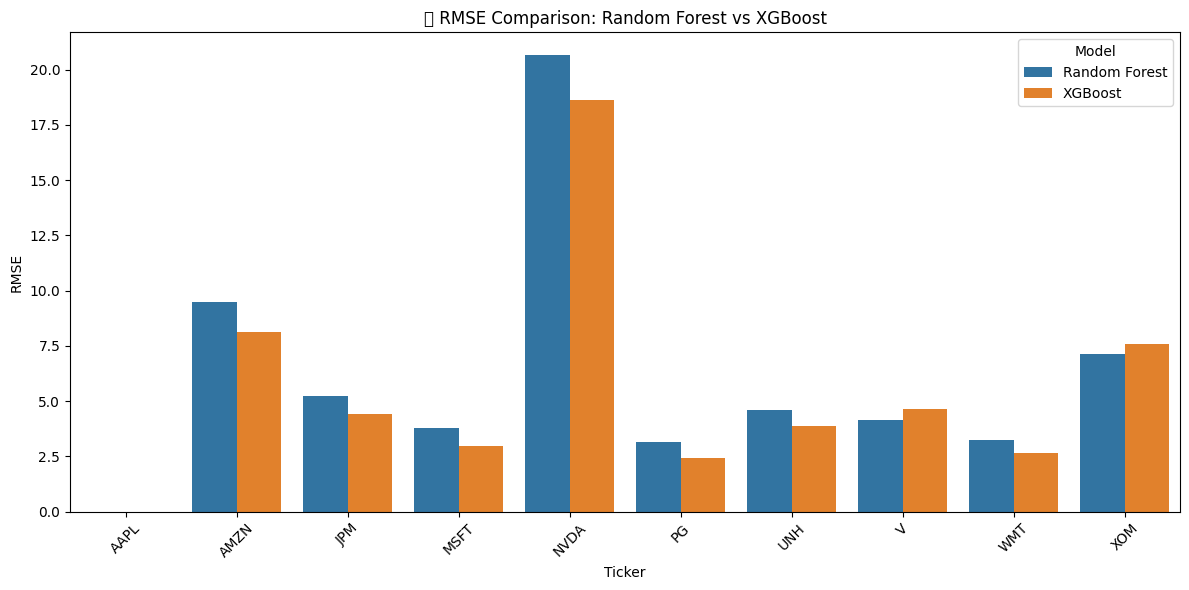

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the combined dataframe
df = pd.read_csv("combined_model_performance.csv")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Ticker", y="RMSE", hue="Model")

plt.title("📉 RMSE Comparison: Random Forest vs XGBoost")
plt.ylabel("RMSE")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("rmse_comparison.png")  # Save for dashboard
plt.show()


<ipython-input-4-fde196820e4c>:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-fde196820e4c>:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("r2_comparison.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


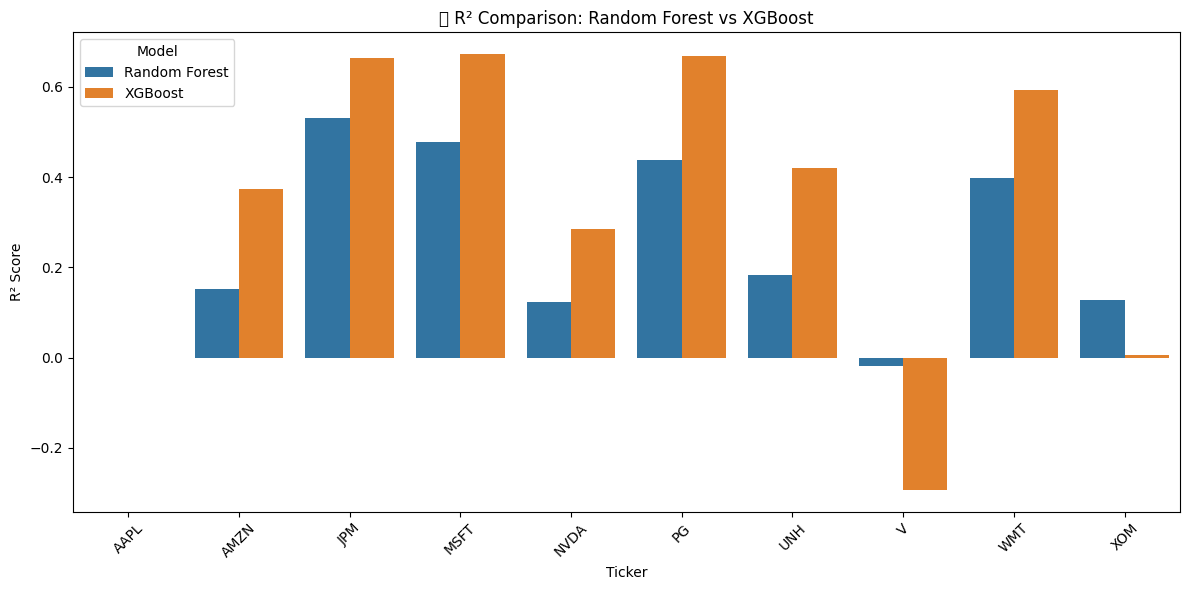

In [4]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Ticker", y="R2", hue="Model")
plt.title("📈 R² Comparison: Random Forest vs XGBoost")
plt.ylabel("R² Score")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("r2_comparison.png")
plt.show()
